## Import necessary modules and check GPU devices

In [5]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms as T
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%pwd

'/Users/wuyilun/Desktop/CV_Project1'

In [7]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

torch:  1.10 ; cuda:  1.10.0
device:  cpu


## Pre-processing

### Load and transform the dataset

In [8]:
# Define the transforms to be applied to the images

# Reference: https://github.com/AIPI540/AIPI540-Deep-Learning-Applications/blob/main/2_computer_vision/CNNs/transfer_learning.ipynb

transform_train = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=30),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

transform_test = T.Compose([
    T.Resize(256), 
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

# Apply the training transform to the training set and load the training set 
data_dir = 'data/final_output_data'
batch_size = 10
dataset_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

# Apply the test transform to the test set and load the test set 
dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train':len(dataloader_train), 'val':len(dataloader_test)}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_test)}
print(dataset_sizes)

{'train': 886, 'val': 382}


### Visualization 

torch.Size([10, 3, 224, 224])
class_names:  ['artificial', 'human']


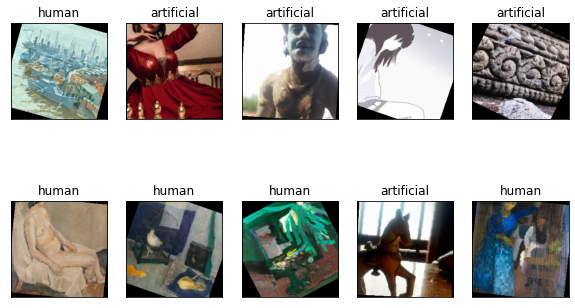

In [9]:
images, labels = next(iter(dataloader_train))
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
batch_size = 10
class_names = dataset_train.classes
print("class_names: ", class_names)
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

## Modeling

### Define model architecture

In [13]:
# Instantiate pre-trained resnet
model = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model.parameters():
    param.requires_grad = False

# Display a summary of the layers of the model and output shape after each layer
summary(model, (images.shape[1:]),batch_size=batch_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 112, 112]           9,408
       BatchNorm2d-2         [10, 64, 112, 112]             128
              ReLU-3         [10, 64, 112, 112]               0
         MaxPool2d-4           [10, 64, 56, 56]               0
            Conv2d-5           [10, 64, 56, 56]          36,864
       BatchNorm2d-6           [10, 64, 56, 56]             128
              ReLU-7           [10, 64, 56, 56]               0
            Conv2d-8           [10, 64, 56, 56]          36,864
       BatchNorm2d-9           [10, 64, 56, 56]             128
             ReLU-10           [10, 64, 56, 56]               0
       BasicBlock-11           [10, 64, 56, 56]               0
           Conv2d-12           [10, 64, 56, 56]          36,864
      BatchNorm2d-13           [10, 64, 56, 56]             128
             ReLU-14           [10, 64,

In [14]:
# Get the number of inputs to final Linear layer
num_features = model.fc.in_features

# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs (2 classes)
model.fc = nn.Linear(num_features, 2)

### Define cost function and optimizer

In [15]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Training && Evaluation

In [16]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

# Train the model
model = train_model(model, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=10)

### Visualization